# Generative Models PHW1

Name: mohamad hosein mehdikhani

Student ID: 400102039

In [ ]:

import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
import scipy.io as sio

# Markov Random Field (10 points)

Consider a 2D image made of binary pixels. Now, suppose you have a noisy version of this image where each pixel has a 0.1 probability of flipping its value. In the figure below, a sample real and noisy image is displayed. In this problem, the goal is to recover the original image by observing the noisy image using a Markov random field.
The energy function of the network on this set of variables is defined as follows:
$$E=\alpha \sum_i  x_i  -\beta \sum_{i,j}x_{i}x_{j} -\gamma \sum_i x_i y_i$$

where the parameters need to be tuned. Based on the image provided in the file `HW1_image.mat`, you must find the real value of each pixel based on its noisy counterpart shown in the file.
To do this, find the optimal value for the above energy function. First, initialize the real pixel values (i.e., $x_i$) with their noisy values given in the file. Then, sequentially check if assigning the value +1 or -1 to each pixel decreases the energy function. Repeat this process until the energy function converges.
- Display the recovered image and report the numeric value of your accuracy.
- Discuss the effect of increasing or decreasing each of the three model parameters and for one of the parameters, demonstrate this effect by changing it and recovering the image again.
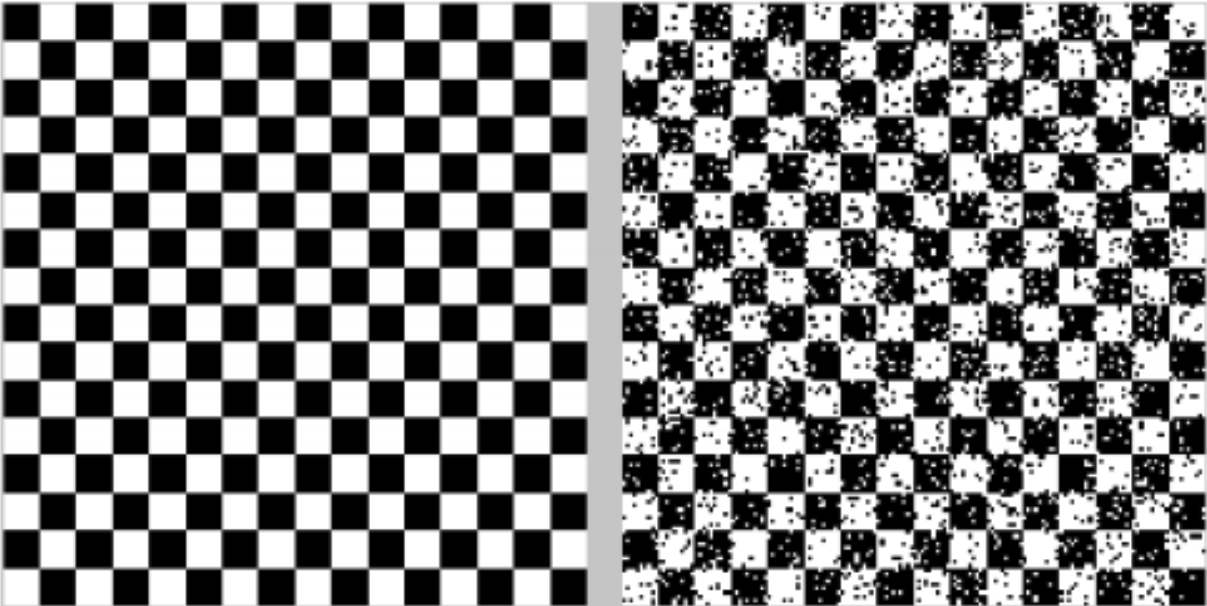

In [ ]:
class MarkovRandomFieldDenoising:
    def __init__(self, image_file, alpha=1.0, beta=10.0, gamma=10.0):
        self.load_data(image_file)
        self.initialize_parameters(alpha, beta, gamma)

    def load_data(self, image_file):
        data = sio.loadmat(image_file)
        self.noisy_image = np.where(data['noisy_image'] == 0, 1, -1)
        self.true_image = np.where(data['original_image'] == 0, 1, -1)
        self.image_shape = self.noisy_image.shape

    def initialize_parameters(self, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.denoised_image = self.noisy_image.copy()

    def local_energy(self, i, j, image, flip=False):
        x_ij = image[i, j]
        if flip:
            x_ij = -x_ij

        unary_term = self.alpha * x_ij

        pairwise_term = 0
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        for ni, nj in neighbors:
            if 0 <= ni < self.image_shape[0] and 0 <= nj < self.image_shape[1]:
                pairwise_term += -self.beta * x_ij * image[ni, nj]

        noisy_term = -self.gamma * x_ij * self.noisy_image[i, j]
        return unary_term + pairwise_term + noisy_term

    def denoise_image(self):
        converged = False
        while not converged:
            converged = True
            for i in range(self.image_shape[0]):
                for j in range(self.image_shape[1]):
                    current_energy = self.local_energy(i, j, self.denoised_image, flip=False)
                    flipped_energy = self.local_energy(i, j, self.denoised_image, flip=True)

                    if flipped_energy < current_energy:
                        self.denoised_image[i, j] = -self.denoised_image[i, j]
                        converged = False
        return self.denoised_image

    def compute_accuracy(self, denoised_image):
        accuracy = np.mean(denoised_image == self.true_image)
        return accuracy

    def plot_images(self, denoised_image):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Noisy Image')
        plt.imshow(self.noisy_image, cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('True Image')
        plt.imshow(self.true_image, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('Denoised Image')
        plt.imshow(denoised_image, cmap='gray')
        plt.show()


Accuracy: 0.9828515625


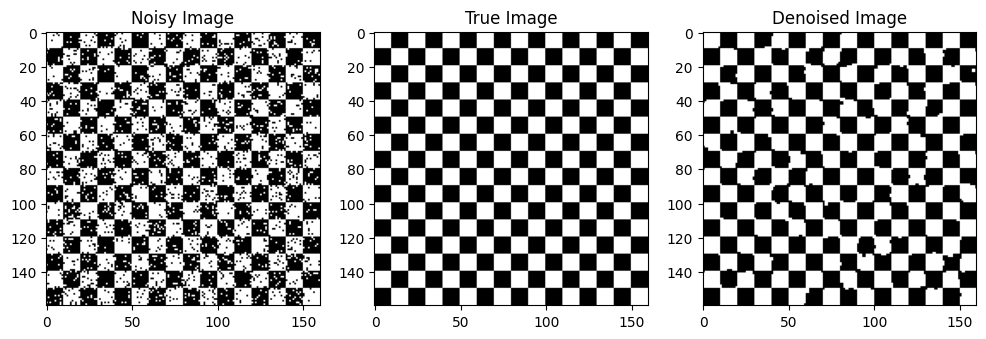

In [ ]:
mrf_denoising = MarkovRandomFieldDenoising('HW1_image.mat')

denoised_image = mrf_denoising.denoise_image()

accuracy = mrf_denoising.compute_accuracy(denoised_image)
print(f"Accuracy: {accuracy}")

mrf_denoising.plot_images(denoised_image)



 Parameter Effects

    α (Unary Term Weight):
        This parameter effects each pixel to have a certain value independently.
        Increasing α: bigger amount makes the one individual pixel have a number on its' own and not effect and be effected by the neighbors.
        Decreasing α: this can improve smoothness. Makes it more dependant on the neighbors.

    β (Pairwise Term Weight):
        The parameter: This can improve the preservation of edges.
        Decreasing β: Reducing β weakens the effect of neighboring pixels. This may result in less smoothness and more pixel-level noise.

    γ (Noisy Image Consistency Term Weight):
        The γ parameter determines the influence of the observed noisy image on the final denoised result.
        Increasing γ: With a higher γ, the denoised image will be more likely to retain values close to the noisy input image.
        Decreasing γ: Lowering γ reduces the effect of the noisy image, allowing the denoising process to diverge more from the noisy values.

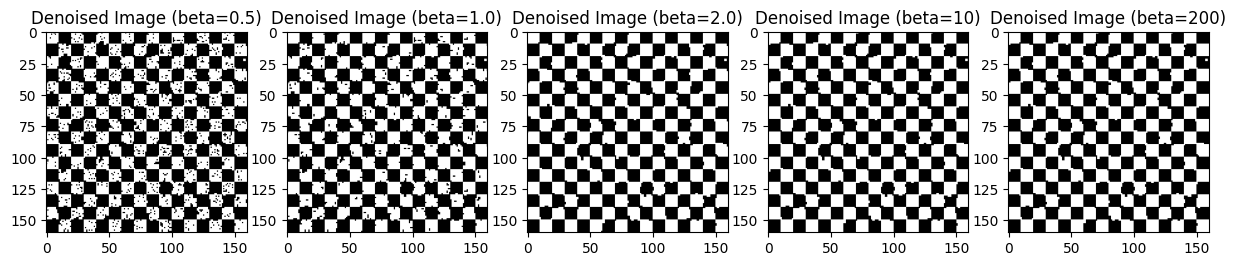

In [ ]:
beta_values = [0.5, 1.0, 2.0,10, 200]
denoised_images = []

for beta in beta_values:
    mrf_denoising = MarkovRandomFieldDenoising('HW1_image.mat', alpha=1.0, beta=beta, gamma=1.0)
    denoised_image = mrf_denoising.denoise_image()
    denoised_images.append((beta, denoised_image))

plt.figure(figsize=(15, 5))
for idx, (beta, denoised_image) in enumerate(denoised_images):
    plt.subplot(1, len(beta_values), idx + 1)
    plt.title(f'Denoised Image (beta={beta})')
    plt.imshow(denoised_image, cmap='gray')
plt.show()


As can be seen in te uot puts bigger beta is good for denoising but after some value there will not be that much of effect.

# Bayesian Network (15 points)

Here we want to implement a Bayesian Network from scratch. The instructions are as follows:

1. `__init__` method:
  - Create a directed acyclic graph (DAG) using `networkx.DiGraph()`.
  - Set up an empty dictionary cpts to store the Conditional Probability Tables (CPTs) for each node.

2. `add_node` method:
	- Use `self.graph.add_node(node)` to add a node to the network graph.

3. `add_edge` method:
  - Use `self.graph.add_edge(parent, child)` to create a directed edge from the parent to the child node.

4. `set_cpt` method:
  - Assign the cpt (which is a dictionary) to the node in `self.cpts[node]`.

5. `draw_network` method:
	-	Use `nx.spring_layout(self.graph)` to arrange the nodes.
	-	Use `nx.draw()` to plot the nodes and edges with labels, and customize the layout.
	-	Display the network using `plt.show()`.

6. `joint_probability` method:
	-	For each node, get its value from `values[node]` and its parents using `self.graph.predecessors(node)`.
	-	If a node has no parents (a root node), multiply the probability from the node's CPT.
	-	If a node has parents, get the parent values, and multiply the conditional probability from its CPT.

7. `compute_posterior` method:
	-	Identify hidden nodes (those not in the query or evidence).
	-	Compute the denominator by summing the joint probability over all possible values of hidden nodes.
	-	Compute the numerator by summing the joint probability of the query and evidence over all hidden values.
	-	Return the ratio of numerator to denominator.

8. `variable_elimination` method:
	-	Initialize factors using `_initialize_factors()`, reducing the CPTs based on evidence.
	-	Identify the nodes to eliminate (all nodes except the query and evidence).
	-	Eliminate each variable by summing it out with `_sum_out()`.
	-	Multiply the remaining factors and normalize to get the final distribution.

9. `_initialize_factors` method:
	-	For each node, get its CPT from `self.cpts`.
	-	If the node has evidence, reduce the CPT using `_reduce_factor()`.
	-	Otherwise, include the CPT unchanged.

10. `_reduce_factor` method:
  - If the node has no parents, just return the CPT for the observed value.
	- If the node has parents, keep only the relevant rows from the CPT based on the observed value.

11. `_sum_out` method:
	-	Find factors that include the variable.
	-	Multiply those factors together.
	-	Use `_sum_out_factor()` to sum out the variable from the combined factor.

12. `_sum_out_factor` method:
	-	For each assignment of the variable, sum over the values where the variable appears.
	-	Create a new factor that does not include the variable.

13. `_multiply_factors` method:
	-	Start with the first factor.
	-	Multiply it with the next factor using `_multiply_two_factors()`, and continue multiplying the remaining factors.

14. `_multiply_two_factors` method:
	-	Combine each pair of assignments from both factors.
	-	Multiply the corresponding probabilities, and return the new combined factor.

15. `_normalize` method:
	-	Compute the sum of all values in the factor.
	-	Divide each value by the total to ensure the probabilities sum to 1.

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools

class BayesianNetwork:
    def __init__(self):

        self.graph = nx.DiGraph()
        self.cpts = {}

    def add_node(self, node):

        self.graph.add_node(node)

    def add_edge(self, parent, child):

        self.graph.add_edge(parent, child)

    def set_cpt(self, node, cpt):

        self.cpts[node] = cpt

    def draw_network(self):

        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=12, font_weight='bold')
        plt.title("Bayesian Network Structure")
        plt.show()

    def joint_probability(self, values):

        prob = 1.0
        for node, value in values.items():
            parents = list(self.graph.predecessors(node))
            if parents:
                # Retrieve parent values from the `values` dictionary, if available
                parent_values = tuple(values[parent] for parent in parents)
                prob *= self.cpts[node].get(parent_values, {}).get(value, 0)
            else:
                # If no parents, use the prior probability directly
                prob *= self.cpts[node].get(value, 0)
        return prob


    def variable_elimination(self, query, evidence):

        factors = self._initialize_factors(evidence)
        elimination_order = set(self.graph.nodes) - set(query.keys()) - set(evidence.keys())

        for var in elimination_order:
            factors = self._sum_out(var, factors)

        result_factor = self._multiply_factors(factors)
        return self._normalize(result_factor)

    def _initialize_factors(self, evidence):

        factors = []
        for node, cpt in self.cpts.items():
            if node in evidence:
                factors.append(self._reduce_factor(cpt, node, evidence[node], list(self.graph.predecessors(node))))
            else:
                factors.append(cpt)
        return factors

    def _reduce_factor(self, cpt, node, value, parents):

        reduced_cpt = {}
        if not parents:
            reduced_cpt = {value: cpt[value]}
        else:
            for parent_values, outcomes in cpt.items():
                if outcomes.get(value) is not None:
                    reduced_cpt[parent_values] = {value: outcomes[value]}
        return reduced_cpt

    def _sum_out(self, var, factors):

        relevant_factors = [f for f in factors if var in f]
        remaining_factors = [f for f in factors if var not in f]
        new_factor = self._sum_out_factor(relevant_factors, var)
        remaining_factors.append(new_factor)
        return remaining_factors

    def _sum_out_factor(self, factors, var):

        combined_factor = self._multiply_factors(factors)
        summed_out_factor = {}
        for assignment, prob in combined_factor.items():
            new_assignment = tuple(v for i, v in enumerate(assignment) if i != var)
            if new_assignment not in summed_out_factor:
                summed_out_factor[new_assignment] = 0
            summed_out_factor[new_assignment] += prob
        return summed_out_factor

    def _multiply_factors(self, factors):

        result_factor = factors[0]
        for factor in factors[1:]:
            result_factor = self._multiply_two_factors(result_factor, factor)
        return result_factor

    def _multiply_two_factors(self, factor1, factor2):

        new_factor = {}
        for assignment1, prob1 in factor1.items():
            for assignment2, prob2 in factor2.items():
                combined_assignment = assignment1 + assignment2
                new_factor[combined_assignment] = prob1 * prob2
        return new_factor

    def _normalize(self, factor):

        total = sum(factor.values())
        for k in factor:
            factor[k] /= total
        return factor
    import itertools

    def compute_posterior(self, query, evidence):
        hidden_nodes = set(self.graph.nodes) - set(query.keys()) - set(evidence.keys())


        total_prob_query = 0.0
        for values in itertools.product([0, 1], repeat=len(hidden_nodes)):
            hidden_assignment = dict(zip(hidden_nodes, values))
            full_assignment = {**query, **evidence, **hidden_assignment}
            total_prob_query += self.joint_probability(full_assignment)


        total_prob_evidence = 0.0
        for values in itertools.product([0, 1], repeat=len(hidden_nodes)):
            hidden_assignment = dict(zip(hidden_nodes, values))
            full_assignment = {**evidence, **hidden_assignment}
            total_prob_evidence += self.joint_probability(full_assignment)


        return total_prob_query / total_prob_evidence if total_prob_evidence > 0 else 0





## Example
Here you must implement the following network using the `BayesianNetwork()` class you wrote:

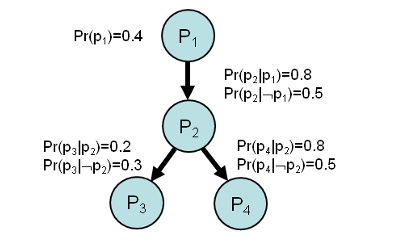

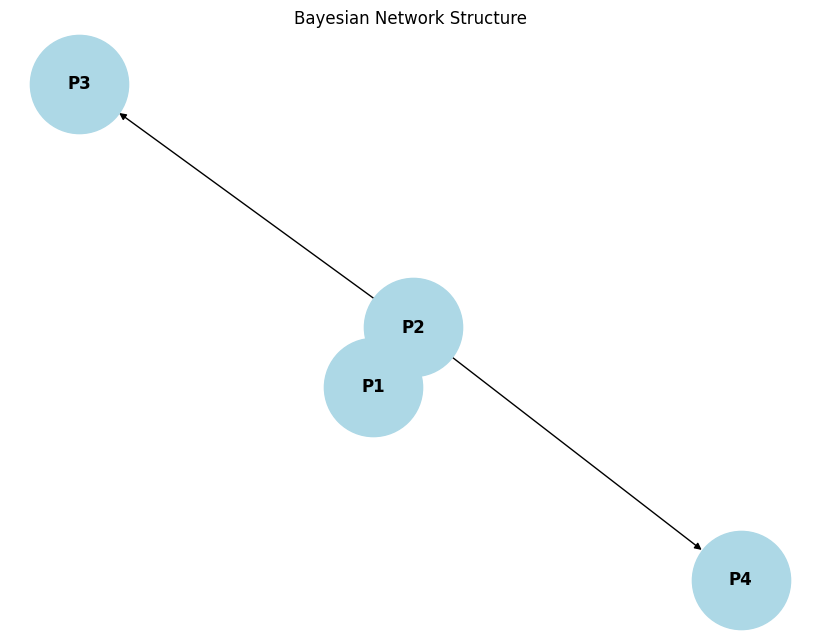

In [38]:

bn = BayesianNetwork()


bn.add_node("P1")
bn.add_node("P2")
bn.add_node("P3")
bn.add_node("P4")


bn.add_edge("P1", "P2")
bn.add_edge("P2", "P3")
bn.add_edge("P2", "P4")

bn.set_cpt("P1", {1: 0.4, 0: 0.6})
bn.set_cpt("P2", {(1,): {1: 0.8, 0: 0.2}, (0,): {1: 0.5, 0: 0.5}})
bn.set_cpt("P3", {(1,): {1: 0.2, 0: 0.8}, (0,): {1: 0.3, 0: 0.7}})
bn.set_cpt("P4", {(1,): {1: 0.8, 0: 0.2}, (0,): {1: 0.5, 0: 0.5}})


bn.draw_network()


Now fill in the Conditional Probability Tables (CPTs).

In [29]:


P1 = {
    1: 0.4,
    0: 0.6
}

P2 = {
    (1,): {1: 0.8, 0: 0.2},
    (0,): {1: 0.5, 0: 0.5}
}

P3 = {
    (1,): {1: 0.2, 0: 0.8},
    (0,): {1: 0.3, 0: 0.7}
}

P4 = {
    (1,): {1: 0.8, 0: 0.2},
    (0,): {1: 0.5, 0: 0.5}
}


bn.set_cpt('P1', P1)
bn.set_cpt('P2', P2)
bn.set_cpt('P3', P3)
bn.set_cpt('P4', P4)


### Question 1

Calculate $Pr(p_1 , p_2, \neg p_3, p_4)$ by using the `joing_probability(values)` method.

In [31]:
values = {'P1': 1, 'P2': 1, 'P3': 1, 'P4': 1}
jp = bn.joint_probability(values)
print(f"P{values} = {jp:.4f}")

P{'P1': 1, 'P2': 1, 'P3': 1, 'P4': 1} = 0.0512


### Question 2

Calculate $Pr(p_2, \neg p_3)$ by using the `compute_posterior(query, evidence)` method.

In [37]:
query = {'P2': 1, 'P3': 0}
evidence = {}
posterior = bn.compute_posterior(query, evidence)
print(f'P({query}) = {posterior:.3f}')

KeyError: 'P2'

### Question 3
Calculate $Pr(p_1 | p_2, \neg p_3)$ by using the `compute_posterior(query, evidence)` method.

In [35]:

query = {'P1': 1}
evidence = {'P2': 1, 'P3': 0}
posterior = bn.compute_posterior(query, evidence)
print(f'P({query} | {evidence}) = {posterior:.3f}')

KeyError: 'P1'

## Sampling

### Rejection Sampling

In [ ]:
def rejection_sampling(bn, evidence, num_samples):
    """Rejection sampling for the given Bayesian network."""
    samples = {tuple(v): 0 for v in np.ndindex(*(2 for _ in bn.graph.nodes()))}  # Possible sample counts
    samples_count = 0

    # TODO

    print(f"Total Accepted Samples: {samples_count}")
    print(samples)

### Gibbs Sampling

In [ ]:
def gibbs_sampling(bn, initial_sample, num_iterations):
    """Gibbs sampling for the Bayesian network."""
    sample = initial_sample.copy()
    samples = {tuple(v): 0 for v in np.ndindex(*(2 for _ in bn.graph.nodes()))}  # Initialize sample counts

    # TODO

    print(f"Samples after {num_iterations} iterations:")
    print(samples)